# Fuzzy Demand Classification & Scheduling
## **Problem statement:** How can household energy consumption be classified into low, medium, and high demand levels to enable cost optimization?

> **Goal:** How can household energy consumption patterns be classified into Low, Medium, and High demand levels in a way that reflects both temporal usage variations and dynamic electricity pricing, so that fuzzy logic–based scheduling can enable cost optimization and reduce peak demand?


Notebook overview

This notebook provides a workflow for classifying household energy consumption into Low, Medium, and High demand levels using fuzzy logic, and for simulating load scheduling to reduce electricity costs and peak demand.

It:
* Loads 1-minute household energy data
* Computes hour-specific baselines (P20, P50, P80)
* Builds a fuzzy demand classifier that accounts for load trend and dynamic pricing
* Applies a time-of-use (TOU) scheduling strategy
* Outputs a cost and peak-reduction KPIs and comparison plots

## Imports

In [1]:

import pandas as pd, numpy as np, math
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict
import warnings
warnings.filterwarnings('ignore')

CSV = './house1_2013_1min-kopi.csv'


In [2]:

df = pd.read_csv(CSV, parse_dates=['timestamp']).sort_values('timestamp').set_index('timestamp')
df['aggregate'] = pd.to_numeric(df['aggregate'], errors='coerce')
df = df[df['aggregate'].notna()]
df = df.asfreq('1min')
print('Loaded rows:', len(df))
df.head(3)


Loaded rows: 525600


,aggregate,washing_machine,dishwasher,tv,kitchen_lights,htpc,kettle,toaster,microwave,amp_livingroom,...,subwoofer_livingroom,livingroom_lamp_tv,kitchen_lamp2,utilityrm_lamp,bedroom_d_lamp,childs_table_lamp,childs_ds_lamp,office_lamp1,office_lamp2,office_lamp3
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,507.8,0.0,1.0,94.000,0.0,69.200,1.0,0.0,1.0,23.200,...,0.0,0.5,0.0,28.0,0.0,0.0,0.0,14.0,10.0,7.0
2013-01-01 00:01:00,525.1,0.0,1.0,108.100,0.0,69.400,1.0,0.0,1.0,23.100,...,0.0,0.5,0.0,28.0,0.0,0.0,0.0,14.0,10.0,7.0
2013-01-01 00:02:00,519.5,0.0,1.0,101.556,0.0,69.444,1.0,0.0,1.0,23.111,...,0.0,0.5,0.0,28.0,0.0,0.0,0.0,14.0,10.0,7.0


## Hourly
Calculate percentiles per hour of the day - P20,P59,P80 defines what "low", "typical", "high" usage means

In [3]:

hourly_q = df['aggregate'].groupby(df.index.hour).quantile([0.2, 0.5, 0.8]).unstack()
hourly_q.columns = ['P20','P50','P80']
hourly_q


,P20,P50,P80
timestamp,,,
0,159.3000,207.9000,264.6000
1,157.2000,201.9000,238.9200
2,156.4440,200.0000,235.5560
3,156.0000,192.4000,231.7824
4,156.1000,194.0000,229.5000
5,157.1000,203.3000,256.3200
6,162.6000,213.5000,303.5000
7,183.9000,258.8000,458.4712
8,195.7400,314.4000,529.3106


## Define Fussy Demand classifyer

three imputs:
* Relative low (difference from hourly median base)
* Load Trend ()
* Price level (low/MEdium/High , from TOU pricing)

Output:
* dmeand index (0-100) -> divided into three catagories: low, medium, high.

In [4]:

try:
    import skfuzzy as fuzz
    from skfuzzy.control import Antecedent, Consequent, Rule, ControlSystem, ControlSystemSimulation
    HAS_SKFUZZY = True
except Exception:
    HAS_SKFUZZY = False

@dataclass
class HourlyParams:
    baseline: float
    spread_low: float
    spread_high: float

def tri(x, a, b, c):
    return np.maximum(np.minimum((x-a)/(b-a+1e-9), (c-x)/(c-b+1e-9)), 0.0)

def trapmf(x, a, b, c, d):
    return np.maximum(np.minimum(np.minimum((x-a)/(b-a+1e-9), 1.0), (d-x)/(d-c+1e-9)), 0.0)

class FuzzyDemandClassifier:
    def __init__(self, hourly: Dict[int, HourlyParams], trend_width: float = 40.0):
        self.hourly = hourly
        self.trend_width = trend_width
        self.use_sk = HAS_SKFUZZY
        if self.use_sk:
            self._build_sk()

    def _build_sk(self):
        self.rel_load_universe = np.linspace(-2000, 2000, 2001)
        self.trend_universe = np.linspace(-600, 600, 1201)
        self.price_universe = np.array([1,2,3])
        self.demand_universe = np.linspace(0,100,101)

        self.rel_load = Antecedent(self.rel_load_universe, 'rel_load')
        self.trend = Antecedent(self.trend_universe, 'load trend')
        self.price = Antecedent(self.price_universe, 'price')
        self.demand = Consequent(self.demand_universe, 'demand')

        self.rel_load['low'] = fuzz.trapmf(self.rel_load_universe, [-2000,-2000,-200,-20])
        self.rel_load['med'] = fuzz.trimf(self.rel_load_universe, [-200,0,200])
        self.rel_load['high'] = fuzz.trapmf(self.rel_load_universe, [20,200,2000,2000])

        w = self.trend_width
        self.trend['falling'] = fuzz.trapmf(self.trend_universe, [-600,-600,-w,-w/3])
        self.trend['stable'] = fuzz.trimf(self.trend_universe, [-w,0,w])
        self.trend['rising'] = fuzz.trapmf(self.trend_universe, [w/3,w,600,600])

        self.price['low'] = fuzz.trimf(self.price_universe, [1,1,2])
        self.price['med'] = fuzz.trimf(self.price_universe, [1,2,3])
        self.price['high'] = fuzz.trimf(self.price_universe, [2,3,3])

        self.demand['low'] = fuzz.trimf(self.demand_universe, [0,15,35])
        self.demand['med'] = fuzz.trimf(self.demand_universe, [30,50,70])
        self.demand['high'] = fuzz.trimf(self.demand_universe, [65,85,100])

        rules = [
            Rule(self.price['high'] & self.rel_load['high'], self.demand['high']),
            Rule(self.price['high'] & self.rel_load['med'] & self.trend['rising'], self.demand['high']),
            Rule(self.price['med'] & self.rel_load['high'], self.demand['high']),
            Rule(self.price['low'] & self.rel_load['high'] & self.trend['falling'], self.demand['med']),
            Rule(self.price['low'] & self.rel_load['low'], self.demand['low']),
            Rule(self.rel_load['med'] & self.trend['stable'], self.demand['med'])
        ]
        self.ctrl = ControlSystem(rules)
        self.sim = ControlSystemSimulation(self.ctrl)

    def _hour_params(self, ts):
        h = int(ts.hour) if hasattr(ts,'hour') else int(ts)
        return self.hourly.get(h, HourlyParams(0.0, 150.0, 250.0))

    def _scale_rel_for_hour(self, rel, hp: HourlyParams):
        span_low = max(1.0, hp.spread_low)
        span_high = max(1.0, hp.spread_high)
        scaled = np.where(rel < 0, rel/span_low*150.0, rel/span_high*150.0)
        return np.clip(scaled, -2000, 2000)

    def tri(self, x, a, b, c):
        return tri(x,a,b,c)

    def trapmf(self, x, a, b, c, d):
        return trapmf(x,a,b,c,d)

    def _eval_custom(self, rel_scaled, trend, price_level):
        rl_low = trapmf(rel_scaled, -2000,-2000,-200,-20)
        rl_med = tri(rel_scaled, -200,0,200)
        rl_high = trapmf(rel_scaled, 20,200,2000,2000)

        w = self.trend_width
        rp_fall = trapmf(trend, -600,-600,-w,-w/3)
        rp_stab = tri(trend, -w,0,w)
        rp_rise = trapmf(trend, w/3,w,600,600)

        pr_low = 1.0 if price_level<=1.2 else (0.0 if price_level>=2 else 0.5)
        pr_med = 1.0 if abs(price_level-2)<0.2 else 0.5 if 1.2<price_level<2.8 else 0.0
        pr_high = 1.0 if price_level>=2.8 else (0.0 if price_level<=2 else 0.5)

        acts = []
        acts.append(('high', min(pr_high, rl_high)))
        acts.append(('high', min(pr_high, rl_med, rp_rise)))
        acts.append(('high', min(pr_med, rl_high)))
        acts.append(('med',  min(pr_low, rl_high, rp_fall)))
        acts.append(('low',  min(pr_low, rl_low)))
        acts.append(('med',  min(rl_med, rp_stab)))

        low_lvl = max([a for l,a in acts if l=='low']+[0.0])
        med_lvl = max([a for l,a in acts if l=='med']+[0.0])
        high_lvl = max([a for l,a in acts if l=='high']+[0.0])

        xs = np.linspace(0,100,101)
        low_mf = tri(xs, 0,15,35)*low_lvl
        med_mf = tri(xs, 30,50,70)*med_lvl
        high_mf = tri(xs, 65,85,100)*high_lvl
        agg = np.maximum(np.maximum(low_mf, med_mf), high_mf)
        if agg.sum()<1e-9:
            return 0.0
        return float((xs*agg).sum()/agg.sum())

    def compute_index(self, ts, rel_load, trend, price_level):
        hp = self._hour_params(ts)
        rel_scaled = self._scale_rel_for_hour(np.array([rel_load]), hp)[0]
        if self.use_sk:
            self.sim.input['rel_load'] = float(rel_scaled)
            self.sim.input['load_trend'] = float(trend)
            self.sim.input['price'] = float(price_level)
            try:
                self.sim.compute()
                return float(self.sim.output['demand'])
            except Exception:
                return self._eval_custom(rel_scaled, trend, price_level)
        else:
            return self._eval_custom(rel_scaled, trend, price_level)

    def bucket(self, index: float) -> str:
        return 'Low' if index<35 else ('Medium' if index<70 else 'High')


_can use skfuzzy.control.visualization to plot the membership functions and verify their overlaps._

## Build Controller

In [5]:

# Build controller
hourly = {}
for h, row in hourly_q.iterrows():
    p20, p50, p80 = float(row['P20']), float(row['P50']), float(row['P80'])
    hourly[int(h)] = HourlyParams(baseline=p50, spread_low=max(1.0, p50-p20), spread_high=max(1.0, p80-p50))

delta = df['aggregate'].diff().dropna()
sigma = float(delta.std()) if not delta.empty else 30.0
trend_width = float(np.clip(2.0*sigma, 20.0, 200.0))
controller = FuzzyDemandClassifier(hourly, trend_width=trend_width)
print('scikit-fuzzy available:', HAS_SKFUZZY, '| trend_width:', trend_width)


scikit-fuzzy available: False | trend_width: 200.0


## Feature Engineering for Backtest  
*(Preparing input features and running the system on past data to measure cost and peak reduction performance)*

* Rolling averages for load trend detection
* A synthetic TOU price schedule

In [6]:
# Build features for backtest
d = df.copy()
d['baseline_h'] = d.index.hour.map(hourly_q['P50'])
d['rel_load'] = d['aggregate'] - d['baseline_h']
d['r5'] = d['aggregate'].rolling('5min', min_periods=1).mean()
d['r30'] = d['aggregate'].rolling('30min', min_periods=1).mean()
d['load_trend'] = d['r5'] - d['r30']

def tou_price(ts):
    h = ts.hour
    if (7 <= h < 10) or (17 <= h < 21):
        return 3
    elif 10 <= h < 17:
        return 2
    else:
        return 1
d['price_level'] = d.index.map(tou_price)


## Copute Fuzzy demand index

In [9]:

d['demand_index'] = [controller.compute_index(ts, rl, rp, p) for ts, rl, rp, p in zip(d.index, d['rel_load'], d['load_trend'], d['price_level'])]
d['demand_bucket'] = pd.cut(d['demand_index'], bins=[-1,35,70,101], labels=['Low','Medium','High'])
d[['aggregate','rel_load','load_trend','price_level','demand_index','demand_bucket']].head(5)


,aggregate,rel_load,load_trend,price_level,demand_index,demand_bucket
timestamp,,,,,,
2013-01-01 00:00:00,507.800,299.900,0.0,1,0.0,Low
2013-01-01 00:01:00,525.100,317.200,0.0,1,0.0,Low
2013-01-01 00:02:00,519.500,311.600,0.0,1,0.0,Low
2013-01-01 00:03:00,512.667,304.767,0.0,1,0.0,Low
2013-01-01 00:04:00,512.300,304.400,0.0,1,0.0,Low


## Scheduling — Deferrable Loads
Flexible loads are rescheduled from peak-price periods to off-peak hours

In [10]:

# Deferrables and smart aggregate
deferrables = [c for c in ['washing_machine','dishwasher','tumble_dryer'] if c in d.columns]
for c in deferrables:
    d[c] = pd.to_numeric(d[c], errors='coerce').fillna(0.0)
d['def_power'] = d[deferrables].sum(axis=1) if deferrables else 0.0

d['def_deferred'] = 0.0
d['def_released'] = 0.0
d['smart_aggregate'] = d['aggregate'].copy()

for day, group in d.groupby(d.index.date):
    bucket = 0.0
    for ts, row in group.iterrows():
        p = row['price_level']; dem = row['demand_bucket']
        orig_def = row['def_power']
        if p==3 and dem=='High' and orig_def>0:
            d.at[ts,'def_deferred'] = orig_def
            d.at[ts,'smart_aggregate'] -= orig_def
            bucket += orig_def
        elif p==1 and dem=='Low' and bucket>0:
            cap = max(orig_def, 200.0)
            release = min(bucket, cap)
            d.at[ts,'def_released'] = release
            d.at[ts,'smart_aggregate'] += release
            bucket -= release
    if bucket > 0:
        tail = group.index[-60:]
        add = bucket / max(1, len(tail))
        d.loc[tail, 'smart_aggregate'] += add
        d.loc[tail, 'def_released'] += add
        bucket = 0.0


## Compute KPIs (cost & PEak Reduction)

In [11]:
# KPIs
price_map = {1:0.20, 2:0.35, 3:0.60}
d['price_eur_kwh'] = d['price_level'].map(price_map)

d['kwh_min'] = d['aggregate']/1000.0/60.0
d['smart_kwh_min'] = d['smart_aggregate']/1000.0/60.0

d['baseline_cost'] = d['kwh_min'] * d['price_eur_kwh']
d['smart_cost'] = d['smart_kwh_min'] * d['price_eur_kwh']

baseline_cost = d['baseline_cost'].sum()
smart_cost = d['smart_cost'].sum()
cost_reduction = baseline_cost - smart_cost
cost_reduction_pct = 100.0 * (cost_reduction / baseline_cost)

baseline_peak_w = d['aggregate'].resample('15min').mean().max()
smart_peak_w = d['smart_aggregate'].resample('15min').mean().max()
peak_reduction_w = baseline_peak_w - smart_peak_w
peak_reduction_pct = 100.0 * peak_reduction_w / baseline_peak_w

kpi = pd.DataFrame({
    'metric':['baseline_cost_eur','smart_cost_eur','cost_reduction_eur','cost_reduction_pct',
              'baseline_peak_w','smart_peak_w','peak_reduction_w','peak_reduction_pct'],
    'value':[baseline_cost, smart_cost, cost_reduction, cost_reduction_pct,
             baseline_peak_w, smart_peak_w, peak_reduction_w, peak_reduction_pct]
})
kpi


,metric,value
0,baseline_cost_eur,1287.177639
1,smart_cost_eur,1254.245892
2,cost_reduction_eur,32.931746
3,cost_reduction_pct,2.558446
4,baseline_peak_w,4216.123733
5,smart_peak_w,4695.102517
6,peak_reduction_w,-478.978783
7,peak_reduction_pct,-11.360643


## Visualization

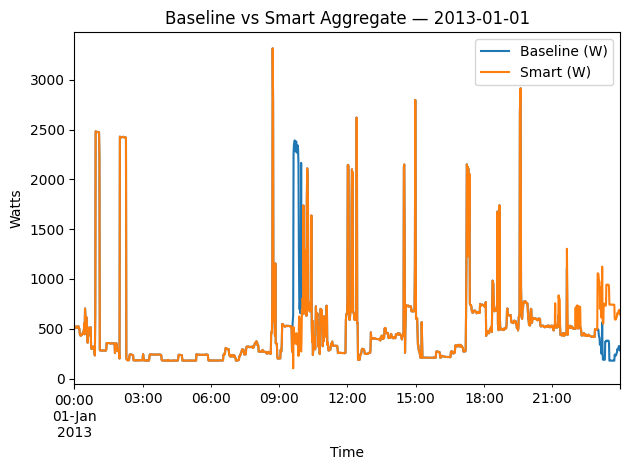

In [12]:
# Daily load Comparison - actual power profile for one specific day
import pandas as pd
day0 = d.index[0].normalize()
sample_day = d.loc[day0.strftime('%Y-%m-%d')]
if isinstance(sample_day, pd.Series):
    sample_day = sample_day.to_frame().T

plt.figure()
sample_day['aggregate'].plot(label='Baseline (W)')
sample_day['smart_aggregate'].plot(label='Smart (W)')
plt.legend()
plt.title(f'Baseline vs Smart Aggregate — {day0.date()}')
plt.xlabel('Time'); plt.ylabel('Watts')
plt.tight_layout()
plt.show()


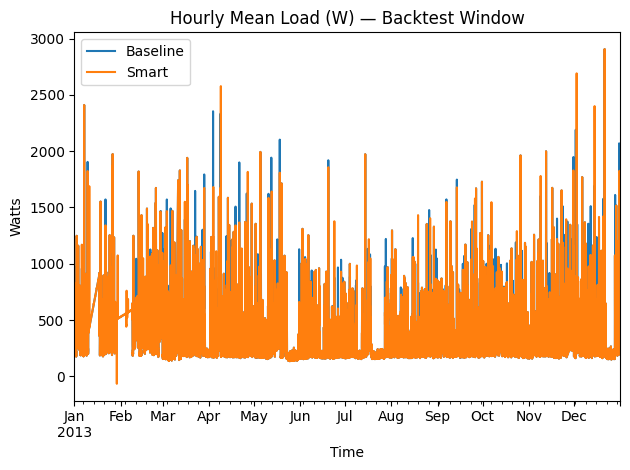

In [13]:
# Hourly mean load over time
plt.figure()
(d.resample('H')['aggregate'].mean()).plot(label='Baseline')
(d.resample('H')['smart_aggregate'].mean()).plot(label='Smart')
plt.legend()
plt.title('Hourly Mean Load (W) — Backtest Window')
plt.xlabel('Time'); plt.ylabel('Watts')
plt.tight_layout()
plt.show()


In [14]:
# Save KPIs to CSV
kpi_path = './fuzzy_kpis.csv'
kpi.to_csv(kpi_path, index=False)
print('Saved KPIs to', kpi_path)


Saved KPIs to ./fuzzy_kpis.csv
